# Number of wrong neutrons in log spir polarizer

In [1]:
from new_log_spir.LogSpir import LogSpir, Neutron
from matplotlib.widgets import Slider
import numpy as np
import matplotlib.pyplot as plt
import run_mcstas as rms
import random as rn
import cycler
from scipy.ndimage import gaussian_filter1d
def integrate_between(x_vals: np.array, y_vals: np.array, xmin: float, xmax: float):
    """integrates y_vals corresponding to x_vals from xmin to xmax (best choice)

    Args:
        x_vals (np.array): x_vals to which the xmin and xmax
        y_vals (np.array): y_vals to their x_vals
        xmin (float): lower bound of integration
        xmax (float): upper bound of integration
    """
    min_ind = np.argmin(np.abs(x_vals-xmin))
    max_ind = np.argmin(np.abs(x_vals-xmax))
    try:
        return np.sum(y_vals[min_ind: max_ind+1])
    except IndexError:
        return np.sum(y_vals[min_ind: max_ind])

def adjust_branches(log: LogSpir, angle_neut: float):
    log.branches = 3
    while True:
        angle = (log.branches-1)*log.phi_rot+log.theta_end
        height = np.sin(angle)*log.zend
        if height/log.zend < angle_neut:
            log.branches += 3
        else:
            break


def return_mcstas_simulation(log: LogSpir):
    
    sim = rms.McstasSimulation("/home/cherb/LRZSync/Doktorarbeit/Mieze/Logarithmic_Spiral/mcstas_component/", "reverse_test.instr")
    sim.num_neutrons = log.n_neutrons
    sim.new_compile = False
    #we have to check how many mirror branches we need
    adjust_branches(log, 0.023/(0.675-0.06))
    pd = sim.return_params_dict()
    pd['zmin'] = log.zstart
    pd['zmax'] = log.zend
    pd['mValue'] = log.m
    pd['source_width'] = log.source_width
    pd['L_source'] = log.lambda_source
    pd['dL'] = 0
    pd['phi_rot'] = log.phi_rot
    pd['psi'] = log.psi
    pd['branches'] = log.branches
    print(log.branches)
    data_dict = sim.run_and_return(pd)
    images_dict = sim.return_images_data()
    x = np.linspace(-1.3, 1.3, 1001)
    total = np.sum(images_dict['psdbeforelog.dat'][:1000])
    ints = np.sum(images_dict['psdafterlog.dat'][:1000], axis=0)/total
    
    meta = sim.return_images_metadata()
    met = meta['psdafterlog.dat']
    print(met[' xylimits'])
    #fig, ax = plt.subplots(1)
    #samplemin = -0.25
    #samplemax = 0.25
    #min_ind = np.argmin(np.abs(x-samplemin))
    #max_ind = np.argmin(np.abs(x-samplemax))
    #print(min_ind, max_ind)
    #mcratio = np.sum(ints[min_ind: max_ind])/np.sum(ints)
    #ax.plot(x, ints, marker=' ', linestyle='-')
    #plt.show()
    sim.delete_last_folder()
    return x, ints

def return_phython_sim(log: LogSpir):
    #fig, ax = plt.subplots(1, figsize=(7, 7))
    v0 = 791 #lam = 5
    theta_end = log.theta_end
    theta_range = np.linspace(0, theta_end, 10001)
    z, x = log.return_cart_coords(theta_range)
    hist = []
    ms = 0.0198/(0.675-0.06)
    for slope in np.linspace(-ms, ms, log.n_neutrons//100):
        z0 = 0.675-0.06
        vz = -1
        vx = -slope
        x0 = slope*z0+(rn.uniform(0, 1)-0.5)*log.source_width
        vz, vx = v0*vz/(vx**2+vz**2)**0.5, v0*vx/(vx**2+vz**2)**0.5
        neutron = Neutron(z0, x0, vz, vx)
        path, neutron = log.propagate_neutron(neutron)
        z_path, x_path = zip(*[k[:2] for k in path])
        #ax.set_aspect('equal')

        if neutron.vz > 0:
            z_path=list(z_path)+[2*log.zend]
            x_path=list(x_path)+[neutron.x+neutron.vx/neutron.vz*(2*log.zend-neutron.z)]
            #ax.plot([neutron.z, 2*log.zend], [neutron.x, neutron.x+neutron.vx/neutron.vz*(2*log.zend-neutron.z)])
        else:
            z_path=list(z_path)+[0]
            x_path=list(x_path)+[neutron.x+neutron.vx/neutron.vz*(0-neutron.z)]
            #ax.plot([neutron.z, 0], [neutron.x, neutron.x+neutron.vx/neutron.vz*(0-neutron.z)])
        hist += [x_path[-1]]

    hist = np.histogram(hist, bins = 1001, range=(-0.013, 0.013))
    xhist = 100*(hist[1][:-1]+0.5*(hist[1][1]-hist[1][0]))#all in centimeters
    return xhist, hist[0]

def compare_mcstas_python(logspir: LogSpir, samplemin=-0.3, samplemax=0.3):
    """conducts a mcstas simulation of a spefic logspir object and a acorresponding python simulation and compares the two

    Args:
        logspir (LogSpir): logspir object to simulate
    """
    #first setup the mcstas simulation
    fig, ax = plt.subplots(1)
    log = logspir
    #dealing with the McStas simulation
    x_mac, y_mac = return_mcstas_simulation(log)
    print(x_mac, y_mac)
    y_mac = y_mac/np.sum(y_mac)
    ratio_mac = integrate_between(x_mac, y_mac, samplemin, samplemax)/np.sum(y_mac)
    ax.plot(x_mac, y_mac, marker=' ', label='McStas, wrong portion {:.2}'.format(ratio_mac))

    x_pyth, y_pyth = return_phython_sim(log)
    y_pyth = y_pyth/np.sum(y_pyth)
    ratio_pyth = integrate_between(x_pyth, y_pyth, samplemin, samplemax)/np.sum(y_pyth)
    ax.plot(x_pyth, y_pyth, marker=' ', label='Python, wrong portion {:.2}'.format(ratio_pyth))
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('integrated int (arb. u.)')
    ax.vlines([samplemin, samplemax], 0, 0.007)
    ax.legend()


def investigate_phi_rot(log, source_width: float = 0.002, min_phi=0.2, max_phi=0.8):#this pls
    ratios = []
    th_end = log.theta_end
    print(th_end)
    phi_rots = np.linspace(th_end*min_phi, th_end*max_phi, 11)
    all_y_data = []
    sample_min = -log.source_width/2*100
    sample_max =  log.source_width/2*100
    for ind, phi in enumerate(phi_rots):
        log.phi_rot = phi
        x_mac, y_mac = return_mcstas_simulation(log)
        all_y_data.append(y_mac)
        between = integrate_between(x_mac, y_mac, sample_min, sample_max)
        ratios.append(between)
    all_y_data = np.array(all_y_data)
    color = plt.cm.tab10(np.linspace(0, 1, 11))
    plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    all_y_data_smoothed = gaussian_filter1d(all_y_data, 2, axis=1)
    ratios_smooth = [integrate_between(x_mac, data, sample_min, sample_max) for ind, data in enumerate(all_y_data_smoothed)]
    totalite= np.max(all_y_data_smoothed)
    print(totalite)
    print(ratios_smooth)
    fig, ax = plt.subplots(1)
    for ind, phi in enumerate(phi_rots): 
        ax.plot(x_mac, all_y_data_smoothed[ind]-totalite*ind, marker=' ', label=r"$\phi_{{rot}}/\theta_{{end}} = {:.2}$".format(phi/log.theta_end), color=color[ind%10])
        ax.hlines(-totalite*ind, -1, 1)
        ax.vlines([sample_min, sample_max], -11*totalite, totalite, linewidth=0.5)
    ax.set_title(r'$\psi = {}°,\ w={}$ mm'.format(log.psi, log.source_width))
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('intensity (arb. u.)')
    ax.legend()
    print(ratios)
    fig, ax = plt.subplots(1)
    for ind, phi in enumerate(phi_rots):
        ax.plot(phi*180/3.1415/(log.theta_end*180/3.1415), ratios_smooth[ind], color=color[ind%10], marker='s')
    ax.set_xlabel(r'$\phi_{rot}/\theta_{end}$')
    ax.set_ylabel('ratio of wrong neutrons')
    ax.set_title(r'$\psi = {}°,\ w={}$ mm'.format(log.psi, log.source_width))
    log.theta_end*180/3.1415
    plt.show()
    return x_mac, all_y_data_smoothed


def plot_polarizations(lam):
    psis = np.array([1.0, 1.15, 1.3, 1.45, 1.6, 1.75, 1.9][::])-0.15/2
    source_widths = np.array([0.5, 2, 4, 6][::1])*0.001
    phi_rots = np.linspace(0.2, 0.855, 12)-0.055/2
    for ind, source_width in enumerate(source_widths):
        all_ratio_reshape=np.genfromtxt('2Dmaps/mapwSMALLER_TIGHTER_{}AA{}.txt'.format(lam, source_width))
        pol = (1-all_ratio_reshape)/(1+all_ratio_reshape)
        fig, ax = plt.subplots(1)
        im = ax.pcolormesh(phi_rots, psis, pol)
        ax.set_yticks(np.array([1.0, 1.15, 1.3, 1.45, 1.6, 1.75][::]))
        fig.colorbar(im)
        ax.set_xlabel(r"$\phi_{rot}/\theta_{end}$")
        ax.set_ylabel("$\psi $ (deg)")
        ax.set_title("Polarization, $w = {}$ mm".format(source_width*1000))

def plot_spiral(log: LogSpir):
    """plots the spiral for vizualization
    """
    fig, ax = plt.subplots(1)
    thetas = np.linspace(0, log.theta_end, 1001)
    for b_ind in range(log.branches):
        phi = log.phi_rot*b_ind
        zs, xs = log.return_cart_coords(thetas)
        z_r, x_r = log.rotate_vector(zs, xs, phi)
        ax.plot(z_r, x_r, marker=' ', linestyle='-', color='black')
        ax.plot([0, z_r[-1]], [0, x_r[-1]], marker=' ', linestyle='-', color='red')
    ax.set_xlabel('$z$ (m)')
    ax.set_ylabel('$x$ (m)')
    ax.set_xlim(-0.01, 0.3)
    ax.set_ylim(-0.001, 0.01)
    ax.tick_params(which='both', direction='in', top=True, right=True)
    return ax

def plot_everything_tighter():
    psis = np.array([1.0, 1.15, 1.3, 1.45, 1.6, 1.75, 1.9][::])-0.15/2
    source_widths = np.array([0.5, 2, 4, 6][::1])*0.001
    phi_rots = np.linspace(0.2, 0.855, 12)-0.055/2
    lambdas = np.array([3.5, 4, 4.5, 5])
    all_data = np.zeros((len(lambdas), len(source_widths), len(psis)-1, len(phi_rots)-1))
    for indl, lam in enumerate(lambdas):
        for indw, width in enumerate(source_widths):
            all_ratio_reshape=np.genfromtxt('2Dmaps/mapwSMALLER_TIGHTER_{}AA{}.txt'.format(lam, width))
            all_data[indl, indw, :, :] = all_ratio_reshape
    all_pols = (1-all_data)/(1+all_data)
    ## now start the figure including the slider mechanics
    fig, ax = plt.subplots(1)
    fig.subplots_adjust(left=0.25, bottom=0.25, right=0.8)
    cax = fig.add_axes([0.82, 0.25, 0.05, 0.63])

    im = ax.pcolormesh(phi_rots, psis, all_pols[1, 1, :,: ], vmin=0.8, vmax = 1.0)
    ax.set_yticks(np.array([1.0, 1.15, 1.3, 1.45, 1.6, 1.75][::]))
    fig.colorbar(im, cax=cax)
    ax.set_xlabel(r"$\phi_{rot}/\theta_{end}$")
    ax.set_ylabel("$\psi $ (deg)")
    ax.set_title("Polarization")


    axwidth = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    width_slider = Slider(
        ax=axwidth,
        label=r'$w$ (m)',
        valmin = 0.0005,
        valmax = 0.006,
        valstep= source_widths,
        valinit= 0.002,
    )
    axlam = plt.axes([0.25, 0.03, 0.65, 0.03])
    lam_slider = Slider(
        ax=axlam,
        label=r"$\lambda\ (\mathrm{\AA})$",
        valmin=3.5,
        valmax=5,
        valstep=lambdas,
        valinit=4,
        orientation="horizontal"
    )
    #inset 
    #insetax = fig.add_axes([0, 0.1, 0.2, 0.6])
    #log = LogSpir(0.175, 0.275, 1, 5)
    #ins = plot_spiral(log)
    #insetax = ins
    def update(val):
        lam_ind = np.where(lambdas==lam_slider.val)[0][0]
        source_ind = np.where(source_widths==width_slider.val)[0][0]
        print(lam_ind, source_ind, lambdas[lam_ind], source_widths[source_ind])
        pol = all_pols[lam_ind, source_ind, :, :]
        im = ax.pcolormesh(phi_rots, psis, pol, vmin=0.8, vmax = 1.0)
        ax.set_title(r"polarization at $w$ = {} $\mathrm{{mm}}$, $\lambda = {} \mathrm{{\AA}}$".format(width_slider.val*1000, lam_slider.val))
        fig.colorbar(im, cax=cax)
        fig.canvas.draw_idle()
    
    lam_slider.on_changed(update)
    width_slider.on_changed(update)
    update(0)
    plt.show()


### Testing for plotting the spiral

In [7]:
log = LogSpir(0.175, 0.275, 2, 5)
log.phi_rot=log.theta_end*1
plot_spiral(log)

<AxesSubplot:xlabel='$z$ (m)', ylabel='$x$ (m)'>

In [3]:
%matplotlib auto
plot_everything_tighter()

Using matplotlib backend: QtAgg
1 1 4.0 0.002
1 2 4.0 0.004
1 3 4.0 0.006
1 2 4.0 0.004
1 1 4.0 0.002
2 1 4.5 0.002
3 1 5.0 0.002
2 1 4.5 0.002
1 1 4.0 0.002
2 1 4.5 0.002
3 1 5.0 0.002
2 1 4.5 0.002
1 1 4.0 0.002
2 1 4.5 0.002
2 2 4.5 0.004
2 0 4.5 0.0005
0 0 3.5 0.0005
1 0 4.0 0.0005
2 0 4.5 0.0005
3 0 5.0 0.0005
3 3 5.0 0.006
0 3 3.5 0.006


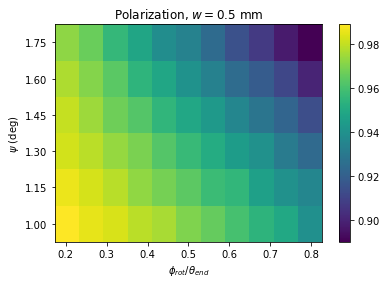

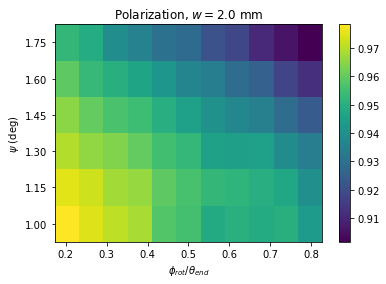

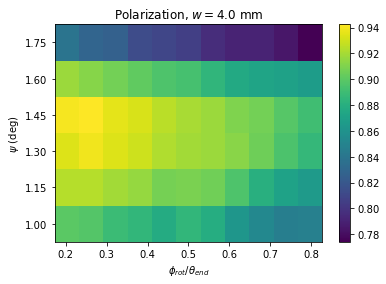

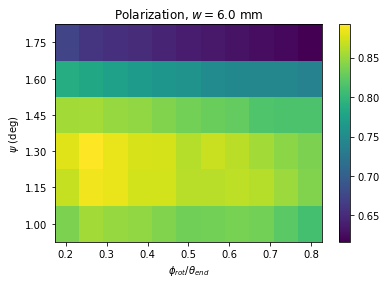

In [ ]:
%matplotlib inline
plot_polarizations('3.5')

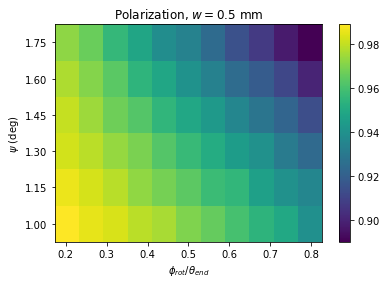

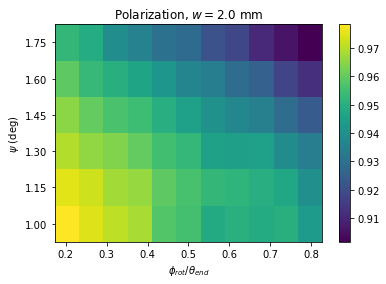

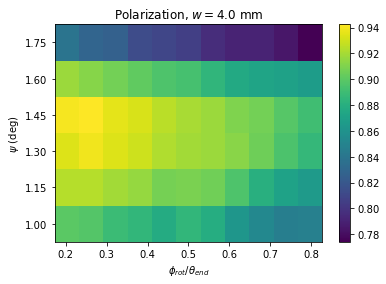

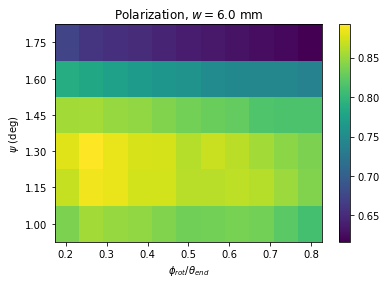

In [5]:
%matplotlib inline
plot_polarizations('3.5')